In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!mkdir model
!unzip glove*.zip -d model
!rm -rf glove*.zip
!pip install emoji

In [ ]:
import numpy as np
import emoji
import matplotlib.pyplot as plt
from lib.emo_utils import *

# 1) Baseline model: Emojifier-V1

## 1.1 Data Loading

In [ ]:
X_train, Y_train = read_csv('https://raw.githubusercontent.com/AdalbertoCq/Deep-Learning-Specialization-Coursera/master/Sequence%20Models/week2/Emojyfier/data/train_emoji.csv')
X_test, Y_test = read_csv('https://raw.githubusercontent.com/AdalbertoCq/Deep-Learning-Specialization-Coursera/master/Sequence%20Models/week2/Emojyfier/data/test_emoji.csv')

In [ ]:
maxLen = len(max(X_train, key=len).split())
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


In [ ]:
# one hot encoding
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
Y_oh_train = convert_to_one_hot(Y_train, C=5)
Y_oh_test = convert_to_one_hot(Y_test, C=5)

In [ ]:
idx = 50
print(X_train[idx])
print(label_to_emoji(Y_train[idx]))
print(Y_train[idx])
print(Y_oh_train[idx])

I missed you
❤️
0
[1. 0. 0. 0. 0.]


## 1.2 Embedding

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./model/glove.6B.50d.txt')

You've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

In [ ]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((50, ))

    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg / len(words)
    return avg

In [ ]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
avg

array([-0.008005  ,  0.56370833, -0.50427333,  0.258865  ,  0.55131103,
        0.03104983, -0.21013718,  0.16893933, -0.09590267,  0.141784  ,
       -0.15708967,  0.18525867,  0.6495785 ,  0.38371117,  0.21102167,
        0.11301667,  0.02613967,  0.26037767,  0.05820667, -0.01578167,
       -0.12078833, -0.02471267,  0.4128455 ,  0.5152061 ,  0.38756167,
       -0.898661  , -0.535145  ,  0.33501167,  0.68806933, -0.2156265 ,
        1.797155  ,  0.10476933, -0.36775333,  0.750785  ,  0.10282583,
        0.348925  , -0.27262833,  0.66768   , -0.10706167, -0.283635  ,
        0.59580117,  0.28747333, -0.3366635 ,  0.23393817,  0.34349183,
        0.178405  ,  0.1166155 , -0.076433  ,  0.1445417 ,  0.09808667])

## 1.3 Model Building

* The equations you need to implement in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels.

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

In [ ]:
def predict(X, Y, W, b, word_to_vec_map):
    m = X.shape[0]
    pred = np.zeros((m, 1))

    for j in range(m):
        words = X[j].lower().split()
        avg = np.zeros((50, ))
        for w in words:
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
    print(f"Accuracy: {np.mean((pred == Y.reshape(Y.shape[0], 1)))}")
    return pred

In [ ]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes
    n_h = 50                                # dimensions of the GloVe vectors

    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))

    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y)

    # Optimization loop
    for t in range(num_iterations):
        for i in range(m):
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost
            cost = -np.sum(Y_oh[i] * np.log(a))

            # Compute gradients
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y, 1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db

        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [ ]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
# print(pred)

Epoch: 0 --- cost = 2.2676818979118387
Accuracy: 0.2878787878787879
Epoch: 100 --- cost = 0.07808983157055333
Accuracy: 0.9393939393939394
Epoch: 200 --- cost = 0.04594248305427018
Accuracy: 0.946969696969697
Epoch: 300 --- cost = 0.03640018094952648
Accuracy: 0.9696969696969697


## 1.4 Evaluation

In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.6428571428571429


In [ ]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


**Word ordering isn't considered in this model**
* Note that the model doesn't get the following sentence correct:
>"not feeling happy"

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy."

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    0    0    7    7
All          9    9   18   13    7   56


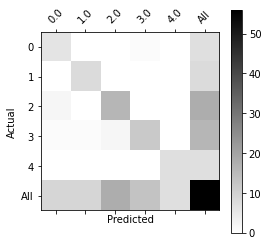

In [ ]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

## 1.5 Conclusion
- Even with a 127 training examples, you can get a reasonably good model for Emojifying.
    - This is due to the generalization power word vectors gives you.
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"*
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words.

# 2) Emojifier-V2 with LSTM

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

## 2.1 Overview of the model

<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/05_sequence_models/05_emojify_with_glove_and_keras_lstm/images/emojifier-v2.png?raw=true" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>



## 2.2 Padding

In [ ]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx,val)

0 I
1 like
2 learning


In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))

    # Loop over the sample
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0

        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set index
            X_indices[i, j] = word_to_index[w]
            j = j + 1
    return X_indices

In [ ]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len = 5)
print(X1)
print(X1_indices)

['funny lol' 'lets play baseball' 'food is ready for you']
[[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


## 2.3 Embedding Layer

1. Initialize the embedding matrix as a numpy array of zeros.
    * The embedding matrix has a row for each unique word in the vocabulary.
        * There is one additional row to handle "unknown" words.
        * So vocab_len is the number of unique words plus one.
    * Each row will store the vector representation of one word.
        * For example, one row may be 50 positions long if using GloVe word vectors.
    * In the code below, `emb_dim` represents the length of a word embedding.
2. Fill in each row of the embedding matrix with the vector representation of a word
    * Each word in `word_to_index` is a string.
    * word_to_vec_map is a dictionary where the keys are strings and the values are the word vectors.
3. Define the Keras embedding layer.
    * Use [Embedding()](https://keras.io/layers/embeddings/).
    * The input dimension is equal to the vocabulary length (number of unique words plus one).
    * The output dimension is equal to the number of positions in a word embedding.
    * Make this layer's embeddings fixed.
        * If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings.
        * In this case, we don't want the model to modify the word embeddings.
4. Set the embedding weights to be equal to the embedding matrix.
    * Note that this is part of the code is already completed for you and does not need to be modified.

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1 # 400001
    emb_dim = word_to_vec_map["cucumber"].shape[0] # 50

    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim)) #(40001, 50)

    # Set each row "idx" of the embedding matrix to be
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer, make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    embedding_layer.build((None, ))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [ ]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][2] = \n", embedding_layer.get_weights()[0][2])

weights[0][2] = 
 [-1.0588    0.26952   0.94632   0.056907  0.2444    0.3781    1.3258
 -0.88515  -0.31155   0.57619  -0.056118 -0.62589  -0.41669  -0.58279
  0.66975   0.11759   0.68662   0.62711  -0.65702  -0.078008 -0.52221
  0.018973  0.97862   0.78516   0.69097   0.47175  -1.1171    0.25342
  0.34635  -1.1866    0.69872   0.66864  -1.2765    0.9261   -0.017565
 -0.25185   1.4484   -0.75393  -0.07427  -0.18682   0.69293  -0.56638
 -0.39572  -0.30951  -0.94394   0.27484   1.0685    0.31138   0.79843
  0.20392 ]


## 2.4 Model Building

In [ ]:
ef sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0] # 132

    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len)) # (132, 10)

    # Loop over the sample
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0

        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set index
            X_indices[i, j] = word_to_index[w]
            j = j + 1

    return X_indices # (132, 10)

In [ ]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):

    # It should be of shape input_shape and dtype 'int32'
    sentence_indices = Input(input_shape, dtype='int32') # (m, 10)

    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index) # (m, 10, 50)

    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) # (m, 10, 50)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    # return state to return both cell state and hidden, while return sequence one H for each input
    X = LSTM(128, return_sequences=True)(embeddings) # (m, 10, 128)

    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) # (m, 10, 128)

    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X) # (m, 128)

    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) # (m, 128)

    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5)(X) # (m, 5)

    # Add a softmax activation
    X = Activation('softmax')(X) # (m, 5)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    return model

In [ ]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [ ]:
model.fit(X_train_indices, Y_train_oh, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 4s 26ms/step - loss: 1.5973 - accuracy: 0.2410
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 1.5267 - accuracy: 0.3136
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 1.4996 - accuracy: 0.3955
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 1.4563 - accuracy: 0.4405
Epoch 5/50
5/5 [==============================] - 0s 25ms/step - loss: 1.3744 - accuracy: 0.5279
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 1.2418 - accuracy: 0.5130
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 1.1333 - accuracy: 0.5698
Epoch 8/50
5/5 [==============================] - 0s 25ms/step - loss: 1.0009 - accuracy: 0.6614
Epoch 9/50
5/5 [==============================] - 0s 25ms/step - loss: 0.8588 - accuracy: 0.7208
Epoch 10/50
5/5 [==============================] - 0s 24ms/step - loss: 0.7554 - accuracy: 0.7332
Epoch 11/50
5/5 [============

In [ ]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 10ms/step - loss: 1.7784 - accuracy: 0.6429

Test accuracy =  0.6428571343421936


You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples.

In [ ]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:❤️ prediction: she got me a present	😄
Expected emoji:❤️ prediction: he is a good friend	😄
Expected emoji:❤️ prediction: I am upset	😞
Expected emoji:❤️ prediction: We had such a lovely dinner tonight	😄
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😄 prediction: are you serious ha ha	😞
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: I worked during my birthday	😄
Expected emoji:😄 prediction: enjoy your break	⚾
Expected emoji:❤️ prediction: valentine day is near	😄
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: I will go dance⚾
Expected emoji:😄 prediction: I like your jacket 	❤️
Expected emoji:😄 prediction: I want to joke	❤️
Expected emoji:😞 prediction: go away	⚾
Expected emoji:😞 predic

In [ ]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞


# 3) What you should remember
- If you have an NLP task where the training set is small, using word embeddings can help your algorithm significantly.
- Word embeddings allow your model to work on words in the test set that may not even appear in the training set.
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be **padded** so that all the examples in a mini-batch have the **same length**.
    - An `Embedding()` layer can be initialized with pretrained values.
        - These values can be either fixed or trained further on your dataset.
        - If however your labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if you would like to return every hidden states or only the last one.
    - You can use `Dropout()` right after `LSTM()` to regularize your network.